In [1]:
using QuantumOptics
using WignerSymbols
using LinearAlgebra
using Plots
using LaTeXStrings
pyplot();

## Sub-Doppler cooling in a $\sigma^--\sigma^+$ molasses configuration
It turns out that if we use an atom with a more complicated electronic structe, we get sub-Doppler cooling through polarization gradients for free in this molasses configuration. 

#### Units
In cooling calculations it's convenient to express all frequencies in units of $\Gamma$, the natural line width. Furthermore, if we chose atomic units (by setting $\hbar = 1$) this means that we effectively solve $\tilde{\mathcal{H}}$, which is related to the original Hamiltonian $\mathcal{H}$ via: $\tilde{\mathcal{H}} = \mathcal{H}/\hbar\Gamma$.

The frequencies $\Omega$ and $\delta$ are understood to be in units of $\Gamma$. This becomes apparent when we look at the jump operator $L$, which, in these units, is simply given by: $L = |g\rangle\langle e|$. (In full units it would carry a factor $\sqrt{\Gamma}$). The full evolution of the density matrix $\rho$ is now given by the master equation
$$
    i\frac{d\rho}{dt} = \left[\mathcal{H}, \rho \right] + L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
(But we don't really need to bother with that since QuantumOptics.jl will do it for us.)

In [152]:
δ = -0.5;
Ω = 0.25;
s₀ = 2 * Ω^2;

We need a basis that includes the three hyperfine ground states $|1, -1\rangle, |1, 0\rangle, |1, 1\rangle$ and the five hyperfine excited states: $|2, -2\rangle \cdots |2, 2\rangle$.
To this order we'll set up an 8-dimensional generic basis, where we'll stick in the couplings by hand. 

In [153]:
Fg = 1;
Fe = 2;
nStates = 2*(Fg + Fe) + 2;
gStates= [[Fg, mFg] for mFg in [-Fg:Fg;]];
eStates = [[Fe, mFe] for mFe in [-Fe:Fe;]];
states = [gStates; eStates];
sbasis = GenericBasis(nStates);

In [154]:
σmincoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, -1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σmincoupling = collect(Iterators.flatten(σmincoupling));
VminMat = vcat(σmincoupling...);
Vminhalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VminMat[:, 1], VminMat[:, 2], VminMat[:, 3], nStates, nStates)));
Vmintot(z) = exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf);

σpluscoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σpluscoupling = collect(Iterators.flatten(σpluscoupling));
VplusMat = vcat(σpluscoupling...);
Vplushalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VplusMat[:, 1], VplusMat[:, 2], VplusMat[:, 3], nStates, nStates)));
Vplustot(z) = exp(im * z) * Vplushalf + dagger(exp(im * z) * Vplushalf);

Define the Hamiltonian and force. The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [155]:
diagonalTerm = SparseOperator(sbasis, complex(Matrix(Diagonal([zeros(2*Fg + 1); ones(2*Fe + 1)]))));

In [156]:
H(z) = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
F(z) = -im * (-exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf) + exp(im * z) * Vplushalf - dagger(exp(im * z) * Vplushalf));

Next define the quantum jump operators.

In [157]:
πcoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 0, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
πcoupling = collect(Iterators.flatten(πcoupling));

rate = [];
L = [];
for coupling in [σmincoupling; σpluscoupling; πcoupling]
    if coupling[3] > 0.
        append!(rate, coupling[3]);
        L = vcat(L, SparseOperator(sbasis, sparse([coupling[2]], [coupling[1]], complex([1.]), nStates, nStates)))
    end
end

rate = float.(rate)
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity:

In [158]:
ψ₀ = Ket(sbasis, [2; 3; 2; zeros(nStates - 3)]/sqrt(17));
T = [0:0.01:500;]

function force(v)
    Hₜ = (t, ρ) -> (H(v * t), L, Ldagger);
    tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);
    return real(expect(F(tout[end] * v), ρₜ[end]))
end

force (generic function with 1 method)

#### Run and plot

In [159]:
vs = ([-1:0.05:1;].^3);
forces = force.(vs);

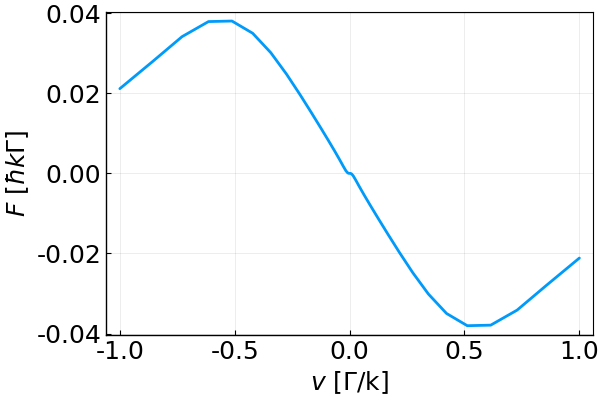

In [160]:
plot(vs, forces,
    width = 2,
#    xlims = (-0.02, 0.02),
#    ylims = (-0.001, 0.001),
    xlabel = L"$v$ [$\Gamma$/k]",
    ylabel = L"$F$ [$\hbar k\Gamma$]",
    frame = true,
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    label = "")

### Steady state convergence & behavior
How does the system converge to the steady state, and what are the population distributions there? (Actually, $s_0 = 2$, so there's a significant portion of population in the excited state.)

In [165]:
ψ₀ = Ket(sbasis, sqrt.([0.45; 0.1; 0.45; zeros(nStates - 3)]));
T = [0:2000;];
Hₜ = (t, ρ) -> (H(1 * t), L, Ldagger);
tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);

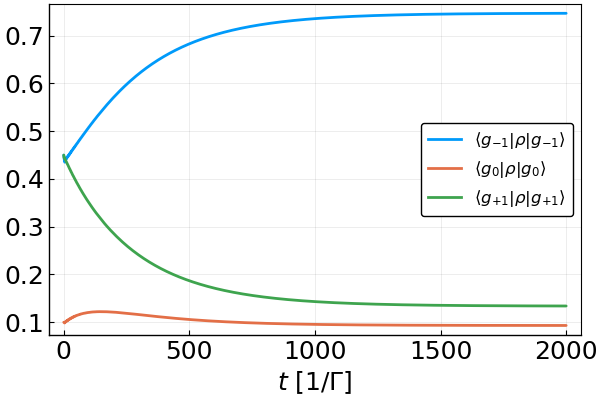

In [166]:
plot(tout, real(expect(DenseOperator(sbasis, Diagonal([1.; zeros(nStates - 1)])), ρₜ)), label = L"$\langle g_{-1} | \rho | g_{-1} \rangle$", width = 2)
plot!(tout, real(expect(DenseOperator(sbasis, Diagonal([0.; 1.; zeros(nStates - 2)])), ρₜ)), label = L"$\langle g_{0} | \rho | g_{0} \rangle$",
#    ylim = (0.43, 0.44),
    frame = true,
    width = 2,
    xlabel = L"$t$ [$1/\Gamma$]",
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    legendfont = font(12))
plot!(tout, real(expect(DenseOperator(sbasis, Diagonal([0.; 0.; 1.; zeros(nStates - 3)])), ρₜ)), label = L"$\langle g_{+1} | \rho | g_{+1} \rangle$", width = 2)